<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/nmt_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural machine translation using encoder-decoder RNN

We show how to implement NMT using an encoder-decoder.
Based on sec 9.7 of http://d2l.ai/chapter_recurrent-modern/seq2seq.html


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import collections

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

# Data

We use a english-french dataset. See [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb#scrollTo=yDmK1xQ9T4IY) for details.

In [ ]:
batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# Encoder-decoder 

## Abstract base class


In [2]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [3]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [4]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## Encoder 

We use a 2-level GRU for the encoder; we set the context as the final state of the GRU. The input to the GRU is the word embedding of each token.


In [6]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [8]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
batch_size = 4
num_steps = 7
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
output, state = encoder(X)
print(output.shape)
print(state.shape)


torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


## Decoder

We use another GRU as the decoder. The initial state is the final state of the encoder, so we must use the same number of hidden units. In addition, we pass in the context (ie final state of encoder) as input to every step of the decoder.


In [9]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [10]:

decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
print(output.shape) # (batch size, number of time steps, vocabulary size)
print(state.shape) # (num layers, batch size, num hiddens)


torch.Size([4, 7, 10])
torch.Size([2, 4, 16])


# Loss function

We use cross entropy loss, but we must mask out target tokens that are just padding. We replace all outputs beyond the valid length to the target value of 0.

In [11]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

We now use this to create a weight mask of 0s and 1s, where 0 corresponds to invalid locations. When we compute the cross entropy loss, we multiply by this weight mask, thus ignoring invalid locations.

In [12]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

As an example, let us create a prediction tensor of all ones of size (3,4,10) and a target label tensor of all ones of size (3,4). We specify the valud lengths to (4,2,0). Thus the first loss should be twice the second. And the third loss should be 0.

In [13]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

# Training

We use teacher forcing, where the inputs to the decoder are "bos" (beginning of sentence), followed by the ground truth target tokens from the previous step, as shown below.


<img src="https://github.com/probml/pyprobml/blob/master/images/seq2seq.png?raw=true">



In [14]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.020, 13024.2 tokens/sec on cuda:0


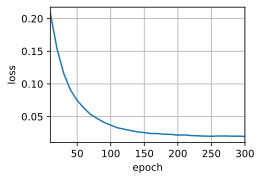

In [15]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()


encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

# Prediction

We use greedy decoding, where the inputs to the decoder are "bos" (beginning of sentence), followed by the most likely target token from the previous step, as shown below. We keep decoding until the model generates "eos" (end of sentence).


<img src="https://github.com/probml/pyprobml/blob/master/images/seq2seq-predict.png?raw=true">


In [16]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

# Evaluation

In the MT community, the standard evaluation metric is known as BLEU (Bilingual Evaluation Understudy), which measures how many n-grams in the predicted target match the true label target.

For example, suppose the prediction is A,B,B,C,D and the target is A,B,C,D,E,F.
There are five 1-grams in the prediction, of which 4 find a match in the target (the second "B" is a "false positive"), so the precision for 1-grams is $p_1=4/5$. Similarly, there are four 2-grams, of which 3 find a match (the bigram "BB" does not occur), so $p_2 = 3/4$. We continue in this way to compute up to $p_k$, where $k$ is the max n-gram length. (Since we are using words, not characters, we typically keep $k$ small, to avoid sparse counts.)

The BLEU score is then defined by
$$
\exp(\min(0, 1-\frac{L_y}{L_p})) \prod_{n=1}^k p_n^{0.5^n}
$$
where $L_y$ is the length of the target label sequence, and $L_p$ is the length of the prediction. 

Since predicting shorter sequences tends to give higher $p_n$ values, short sequences are penalized by the exponential factor. For example, suppose  $k=2$ and the label sequence  is A,B,C,D,E,F.
If the predicted sequence is A,B,B,C,D, 
we have $p_1=4/5$ and $p_2=3/4$, and the penalty factor is
$\exp(1-6/5)=0.818$.
If  the predicted sequence  is A,B,
we have $p_1=p_2=1$, but the penalty factor is $\exp(1−6/2)≈0.135$.



In [19]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [28]:
import pandas as pd
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

data = []
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    score  = bleu(translation, fra, k=2)
    data.append((eng, fra, translation, score))
df = pd.DataFrame.from_records(data, columns=['English', 'Truth', 'Prediction', 'Bleu'])
display(df)

,English,Truth,Prediction,Bleu
0,go .,va !,va !,1.000000
1,i lost .,j'ai perdu .,j'ai perdu perdu,0.686589
2,he's calm .,il est calme .,il est paresseux .,0.658037
3,i'm home .,je suis chez moi .,je suis calme .,0.512480
